First install the repo and requirements.

In [ ]:
%pip --quiet install git+https://github.com/wilson-labs/cola.git

# Spectral Clustering

In this application, we'll show how `CoLA` can be used to perform Spectral Clustering. This application allows us to showcase our `Sparse` operator.

In terms of the data, we will use the arXiv paper citation network of High Energy Physics. This is a directed graph showing the papers cited for each paper in the dataset. As in this case we will consider two papers to be related if at least one cited the other, then it will suffice to use an undirected graph. 

The following command would download the data in case it is not on the `data` folder under the user's `HOME` directory.

In [1]:
![ ! -f "$HOME/data/cit-HepPh.txt" ] && wget -P ~/data https://www.andpotap.com/static/cit-HepPh.txt

In [2]:
import os
import warnings

warnings.filterwarnings('ignore')
input_path = os.path.join(os.environ['HOME'], "data/cit-HepPh.txt")

To pre-process the data we will use the following code:

In [3]:
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np


def load_graph_data(filepath, dtype, xnp, num_edges=-1):
    df = pd.read_csv(filepath, skiprows=4, delimiter="\t", header=None, names=["to", "from"])
    df = df[:num_edges]
    df2 = pd.read_csv(filepath, skiprows=4, delimiter="\t", header=None, names=["from", "to"])
    df2 = df2[:num_edges]
    df_undir = pd.concat((df, df2), axis=0)
    df_undir = df_undir.drop_duplicates()
    id_map = map_nodes_to_id(df_undir["from"].unique())
    N = len(id_map)
    print(f"Found {N:,d} nodes")
    for col in ["from", "to"]:
        df_undir[col] = df_undir[col].map(id_map)
    data = np.ones(shape=len(df_undir))
    row, col = np.array(df_undir["to"]), np.array(df_undir["from"])
    sparse_matrix = csr_matrix((data, (row, col)), shape=(N, N))
    out = transform_to_csr(sparse_matrix, xnp, dtype)
    data, col_ind, rowptr, shape = out
    return data, col_ind, rowptr, shape


def transform_to_csr(sparse_matrix, xnp, dtype):
    data = xnp.array(sparse_matrix.data, dtype=dtype, device=None)
    indices = xnp.array(sparse_matrix.indices, dtype=xnp.int64, device=None)
    indptr = xnp.array(sparse_matrix.indptr, dtype=xnp.int64, device=None)
    return data, indices, indptr, sparse_matrix.shape


def map_nodes_to_id(nodes):
    out = {}
    for idx in range(len(nodes)):
        out[int(nodes[idx])] = idx
    return out

The function `load_graph_data` creates the column indices and row pointers needed for the sparse [CSR format](https://en.wikipedia.org/wiki/Sparse_matrix). Now, we can load the data and create our `Sparse` adjacency matrix as follows

In [4]:
import torch
import cola
from cola.backends import torch_fns as xnp

num_edges = -1
dtype = torch.float64
data, col_ind, rowptr, shape = load_graph_data(input_path, dtype, xnp, num_edges)
Ad = cola.ops.Sparse(data, col_ind, rowptr, shape)

Found 34,545 nodes


Given the adjacency matrix, we can now create the normalized Laplacian defined as $L=I - D^{-1/2} A D^{-1/2}$, where $D$ is the diagonal matrix that contains the degree of each node, $A$ is the adjacency matrix and $I$ is the identity. We can create the Laplacian operator really easily in `CoLA` as

In [5]:
Deg = cola.ops.Diagonal(Ad @ torch.ones((Ad.shape[0], ), dtype=dtype))
Id = cola.ops.I_like(Deg)
Lap = Id - cola.inv(cola.sqrt(Deg)) @ Ad @ cola.inv(cola.sqrt(Deg))
Lap = cola.SelfAdjoint(Lap)
print(f"Size of the Laplacian: {Lap.shape}")

Size of the Laplacian: (34545, 34545)


Where I added the `SelfAdjoint` annotation at the end to ensure that `CoLA` dispatches algorithms for this type of symmetric operator. Spectral Clustering requires that we compute the eigenvectors of the smallest eigenvalues and use those eigenvectors as an embedding of our data. Once we do this, we can then use k-means to cluster points nearby as those points are related to cliques in the original graph.

In [6]:
from sklearn.cluster import KMeans

eigvals, eigvecs = cola.eig(Lap, k=20, which="SM", alg=cola.Lanczos(max_iters=300))


In [11]:
eigvals

tensor([-3.1070e-15, -1.0551e-15,  1.0093e-15,  1.5716e-02,  2.3005e-02,
         3.2201e-02,  4.2626e-02,  4.2914e-02,  4.5332e-02,  4.5939e-02,
         5.5096e-02,  5.7384e-02,  6.2086e-02,  6.5325e-02,  6.7329e-02,
         6.9325e-02,  7.0176e-02,  7.0703e-02,  7.4464e-02,  7.5107e-02],
       dtype=torch.float64)

From the eigenvalues we can determine that there are 3 connected components of the citation graph. Let's identify these components

In [12]:
n_clusters = 3
x_emb = eigvecs.to_dense()[:,:n_clusters]
kmeans = KMeans(n_clusters=n_clusters).fit(x_emb)

And now let's visualize these three components in the basis of these eigenvectors

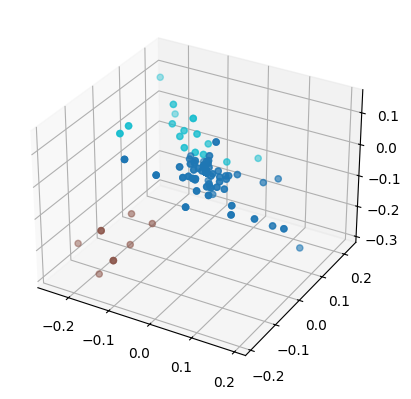

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*x_emb.T, c=kmeans.labels_, cmap="tab10")